In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.gridspec import GridSpec
from mid_simulations.simulation_funcs import (
    get_events_df_for_subject,
)

In [2]:
figure_output_path = (
    '/Users/jeanettemumford/Dropbox/Research/Projects/russ/MID_paper_figures_revision'
)


## How do stimulus duration differences vary across cue types and hit/miss?

In [3]:
def get_all_durations(sub):
    events = get_events_df_for_subject(sub, dataset='ABCD')
    events['TD1_ONSET'] = events['PROBE_ONSET'] + events['PROBE_DURATION']
    events['TD1_DURATION'] = events['FEEDBACK_ONSET'] - events['TD1_ONSET']
    events = events.rename(
        columns={
            'FIXATION_DURATION': 'Fixation_DURATION',
            'PROBE_DURATION': 'Probe_DURATION',
            'CUE_DURATION': 'Cue_DURATION',
            'FEEDBACK_DURATION': 'Feedback_DURATION',
        }
    )
    average_dur = events.groupby(['TRIAL_TYPE', 'PROBE_HIT'])[
        [
            'Cue_DURATION',
            'Fixation_DURATION',
            'Probe_DURATION',
            'TD1_DURATION',
            'Feedback_DURATION',
        ]
    ].mean()
    average_dur = average_dur.reset_index()
    return average_dur

In [4]:
all_dfs_duration = []
for sub in range(1, 501):
    df = get_all_durations(sub)
    df['SUBJECT'] = sub
    all_dfs_duration.append(df)
concatenated_df_duration = pd.concat(all_dfs_duration, ignore_index=True)

In [5]:
df_lg = concatenated_df_duration[concatenated_df_duration['TRIAL_TYPE'] == 'LargeGain']

# Pivot to get Probe_DURATION for PROBE_HIT = 0 and 1 side by side for each subject
pivot_df = df_lg.pivot_table(
    index='SUBJECT', columns='PROBE_HIT', values='Probe_DURATION'
)

# Rename columns for clarity
pivot_df.columns = ['Probe_DURATION_hit_0', 'Probe_DURATION_hit_1']

# Compute the difference: hit_1 - hit_0
pivot_df['Probe_DURATION_diff'] = (
    pivot_df['Probe_DURATION_hit_1'] - pivot_df['Probe_DURATION_hit_0']
)

# Result is a DataFrame with SUBJECT as index and the difference in Probe_DURATION
print(pivot_df.head())

         Probe_DURATION_hit_0  Probe_DURATION_hit_1  Probe_DURATION_diff
SUBJECT                                                                 
1                    0.231375              0.255500             0.024125
2                    0.216500              0.246429             0.029929
3                    0.227538              0.281143             0.053604
4                    0.277500              0.336000             0.058500
5                    0.257143              0.287154             0.030011


In [8]:
pivot_df['Probe_DURATION_diff'].mean() * 1000

np.float64(33.828243145906384)

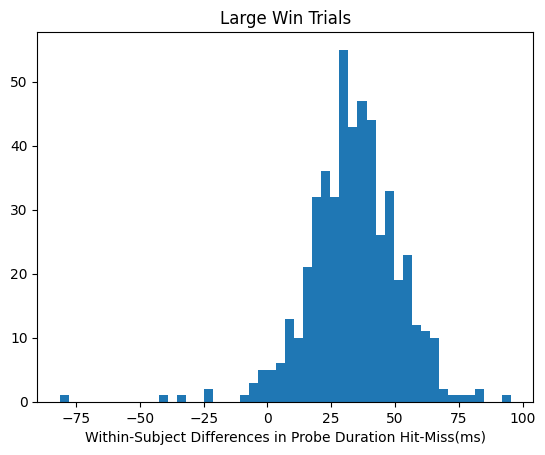

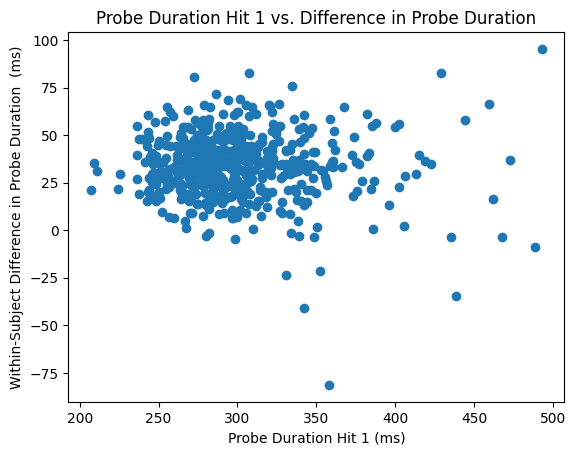

In [9]:
plt.hist(pivot_df['Probe_DURATION_diff'] * 1000, bins=50)
plt.xlabel('Within-Subject Differences in Probe Duration Hit-Miss(ms)')
plt.title('Large Win Trials')
plt.show()

plt.plot(
    pivot_df['Probe_DURATION_hit_1'] * 1000, pivot_df['Probe_DURATION_diff'] * 1000, 'o'
)
plt.xlabel('Probe Duration Hit 1 (ms)')
plt.ylabel('Within-Subject Difference in Probe Duration  (ms)')
plt.title('Probe Duration Hit 1 vs. Difference in Probe Duration')
plt.show()

In [10]:
concatenated_df_duration_long = pd.melt(
    concatenated_df_duration,
    id_vars=['TRIAL_TYPE', 'PROBE_HIT'],
    value_vars=[col for col in concatenated_df_duration.columns if 'DURATION' in col],
    var_name='Stimulus',
    value_name='DURATION',
)
concatenated_df_duration_long['Stimulus'] = concatenated_df_duration_long[
    'Stimulus'
].str.replace('_DURATION', '')
concatenated_df_duration_long['stimulus_outcome'] = concatenated_df_duration_long.apply(
    lambda row: f"{row['Stimulus']}/Hit"
    if row['PROBE_HIT'] == 1
    else f"{row['Stimulus']}/Miss",
    axis=1,
)


In [11]:
print(concatenated_df_duration_long)
print(concatenated_df_duration_long['stimulus_outcome'].unique())

         TRIAL_TYPE  PROBE_HIT  Stimulus  DURATION stimulus_outcome
0         LargeGain        0.0       Cue  1.966625         Cue/Miss
1         LargeGain        1.0       Cue  1.966417          Cue/Hit
2         LargeLoss        0.0       Cue  1.966400         Cue/Miss
3         LargeLoss        1.0       Cue  1.966600          Cue/Hit
4      NoMoneyStake        0.0       Cue  1.966769         Cue/Miss
...             ...        ...       ...       ...              ...
24995  NoMoneyStake        1.0  Feedback  1.683364     Feedback/Hit
24996     SmallGain        0.0  Feedback  1.733455    Feedback/Miss
24997     SmallGain        1.0  Feedback  1.672222     Feedback/Hit
24998     SmallLoss        0.0  Feedback  1.733333    Feedback/Miss
24999     SmallLoss        1.0  Feedback  1.691571     Feedback/Hit

[25000 rows x 5 columns]
['Cue/Miss' 'Cue/Hit' 'Fixation/Miss' 'Fixation/Hit' 'Probe/Miss'
 'Probe/Hit' 'TD1/Miss' 'TD1/Hit' 'Feedback/Miss' 'Feedback/Hit']


In [12]:
summary_stats = concatenated_df_duration_long.groupby('stimulus_outcome')[
    'DURATION'
].agg(['mean', 'std'])
print(summary_stats)

                      mean       std
stimulus_outcome                    
Cue/Hit           1.975350  0.008142
Cue/Miss          1.975268  0.009497
Feedback/Hit      1.655472  0.043913
Feedback/Miss     1.686049  0.048196
Fixation/Hit      2.352119  0.198316
Fixation/Miss     2.236528  0.262509
Probe/Hit         0.301271  0.042727
Probe/Miss        0.270242  0.047277
TD1/Hit           0.070598  0.012010
TD1/Miss          0.070953  0.012474


In [13]:
mean_duration_per_outcome = (
    concatenated_df_duration_long.groupby('Stimulus')['DURATION'].mean().reset_index()
)

min_duration_per_outcome = (
    concatenated_df_duration_long.groupby('Stimulus')['DURATION'].min().reset_index()
)
max_duration_per_outcome = (
    concatenated_df_duration_long.groupby('Stimulus')['DURATION'].max().reset_index()
)
print('minimums')
print(min_duration_per_outcome * 1000)
print('\n maximums')

print(max_duration_per_outcome * 1000)


minimums
                                            Stimulus     DURATION
0  CueCueCueCueCueCueCueCueCueCueCueCueCueCueCueC...  1781.222222
1  FeedbackFeedbackFeedbackFeedbackFeedbackFeedba...  1473.714286
2  FixationFixationFixationFixationFixationFixati...  1500.000000
3  ProbeProbeProbeProbeProbeProbeProbeProbeProbeP...   172.166667
4  TD1TD1TD1TD1TD1TD1TD1TD1TD1TD1TD1TD1TD1TD1TD1T...    53.666667

 maximums
                                            Stimulus     DURATION
0  CueCueCueCueCueCueCueCueCueCueCueCueCueCueCueC...  2039.666667
1  FeedbackFeedbackFeedbackFeedbackFeedbackFeedba...  1789.166667
2  FixationFixationFixationFixationFixationFixati...  3666.333333
3  ProbeProbeProbeProbeProbeProbeProbeProbeProbeP...   497.444444
4  TD1TD1TD1TD1TD1TD1TD1TD1TD1TD1TD1TD1TD1TD1TD1T...   109.000000


In [14]:
mean_duration_per_outcome

,Stimulus,DURATION
0,Cue,1.975309
1,Feedback,1.670761
2,Fixation,2.294324
3,Probe,0.285757
4,TD1,0.070776


In [ ]:
from nilearn.glm.first_level import compute_regressor

# Parameters
frame_times = np.arange(0, 40, 0.1)  # 40s, TR = 0.1s
onset = 10.0
durations_to_check = [1.97, 1.67]

baseline_max_values = {}

for dur in durations_to_check:
    # exp_condition must be shape (3, n_events): [onset_row; duration_row; amplitude_row]
    exp_condition = np.array((onset, dur, 1.0)).reshape(
        3, 1
    )  # shape (3,1) for one event

    creg, names = compute_regressor(
        exp_condition,
        hrf_model='spm',
        frame_times=frame_times,
        con_id=f'duration_{dur}',
    )

    # creg has shape (n_timepoints, n_regressors); take first column
    regressor = creg[:, 0]

    baseline_max = regressor.max() - regressor[0]
    baseline_max_values[dur] = baseline_max

    print(f'Duration {dur:.2f} → baseline_max = {baseline_max:.6f}')


Duration 1.97 → baseline_max = 0.402099
Duration 1.67 → baseline_max = 0.343658


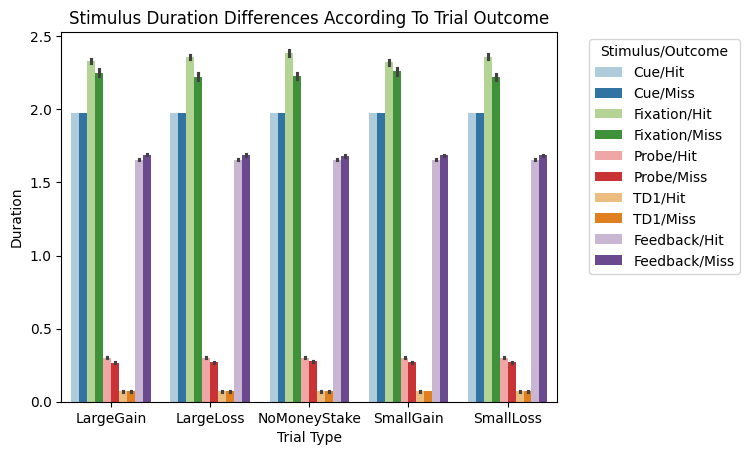

In [12]:
sns.barplot(
    x='TRIAL_TYPE',
    y='DURATION',
    hue='stimulus_outcome',
    data=concatenated_df_duration_long,
    palette='Paired',
    hue_order=[
        'Cue/Hit',
        'Cue/Miss',
        'Fixation/Hit',
        'Fixation/Miss',
        'Probe/Hit',
        'Probe/Miss',
        'TD1/Hit',
        'TD1/Miss',
        'Feedback/Hit',
        'Feedback/Miss',
    ],
)
plt.legend(title='Stimulus/Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Duration')
plt.xlabel('Trial Type')
plt.title('Stimulus Duration Differences According To Trial Outcome')
plt.show()

In [13]:
concatenated_df_duration_long
duration_long_no_td1 = concatenated_df_duration_long[
    concatenated_df_duration_long['Stimulus'] != 'TD1'
]

#### Calculate average difference in fixations between Hits and Miss

In [14]:
mean_duration_per_trial_type = (
    duration_long_no_td1.groupby(['TRIAL_TYPE', 'stimulus_outcome'])['DURATION']
    .mean()
    .reset_index()
)

mean_duration_per_trial_type['Stimulus'] = (
    mean_duration_per_trial_type['stimulus_outcome'].str.split('/').str[0]
)


# Subtract odd rows from even rows
diffs = mean_duration_per_trial_type.iloc[::2].reset_index(drop=True)
diffs['DURATION_DIFF'] = (
    diffs['DURATION'].values
    - mean_duration_per_trial_type.iloc[1::2]['DURATION'].values
)

print(diffs[~diffs['Stimulus'].str.contains('Cue|Feedback|Probe')])
print('')
print(diffs[~diffs['Stimulus'].str.contains('Cue|Feedback|Fixation')])


      TRIAL_TYPE stimulus_outcome  DURATION  Stimulus  DURATION_DIFF
2      LargeGain     Fixation/Hit  2.330631  Fixation       0.079832
6      LargeLoss     Fixation/Hit  2.359066  Fixation       0.135438
10  NoMoneyStake     Fixation/Hit  2.386313  Fixation       0.157921
14     SmallGain     Fixation/Hit  2.323420  Fixation       0.062957
18     SmallLoss     Fixation/Hit  2.361166  Fixation       0.141807

      TRIAL_TYPE stimulus_outcome  DURATION Stimulus  DURATION_DIFF
3      LargeGain        Probe/Hit  0.300891    Probe       0.033828
7      LargeLoss        Probe/Hit  0.300463    Probe       0.031370
11  NoMoneyStake        Probe/Hit  0.301804    Probe       0.026277
15     SmallGain        Probe/Hit  0.301675    Probe       0.032627
19     SmallLoss        Probe/Hit  0.301523    Probe       0.031042


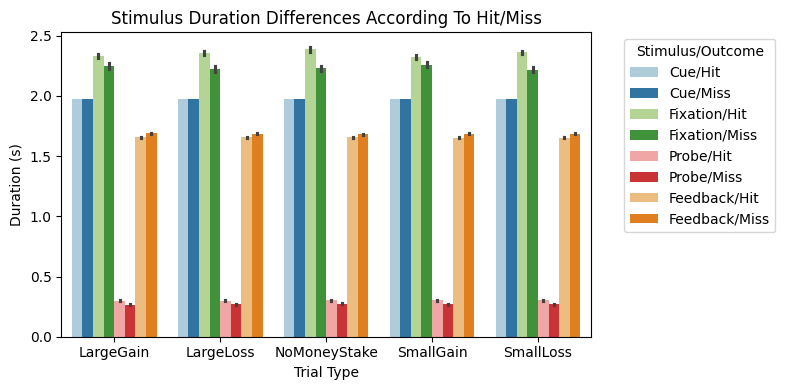

In [15]:
fig_path = f'{figure_output_path}/durations_hit_miss.pdf'

plt.figure(figsize=(8, 4))
sns.barplot(
    x='TRIAL_TYPE',
    y='DURATION',
    hue='stimulus_outcome',
    data=duration_long_no_td1,
    palette='Paired',
    hue_order=[
        'Cue/Hit',
        'Cue/Miss',
        'Fixation/Hit',
        'Fixation/Miss',
        'Probe/Hit',
        'Probe/Miss',
        'Feedback/Hit',
        'Feedback/Miss',
    ],
)
plt.legend(title='Stimulus/Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Duration (s)')
plt.xlabel('Trial Type')
plt.title('Stimulus Duration Differences According To Hit/Miss')
plt.tight_layout()
plt.savefig(fig_path)
plt.show()

## How do RTs vary across cue types and hit/miss?

In [16]:
def get_all_rts(sub):
    events = get_events_df_for_subject(sub, dataset='ABCD')
    events = events.rename(columns={'RT_corrected': 'Response Time'})
    average_rt = events.groupby(['TRIAL_TYPE', 'PROBE_HIT'])[['Response Time']].mean()
    average_rt = average_rt.reset_index()
    return average_rt

In [17]:
all_dfs_rts = []
for sub in range(1, 501):
    df = get_all_rts(sub)
    all_dfs_rts.append(df)
concatenated_df_rts = pd.concat(all_dfs_rts, ignore_index=True)

In [18]:
concatenated_df_rts['stimulus_outcome'] = concatenated_df_duration_long.apply(
    lambda row: 'Hit' if row['PROBE_HIT'] == 1 else 'Miss', axis=1
)


In [19]:
concatenated_df_rts['Response Time'].min(), concatenated_df_rts['Response Time'].max()

(np.float64(105.5), np.float64(1581.0))

In [20]:
mean_rt_per_trial_type = (
    concatenated_df_rts.groupby(['TRIAL_TYPE', 'stimulus_outcome'])['Response Time']
    .mean()
    .reset_index()
)

# Subtract odd rows from even rows
diffs = mean_rt_per_trial_type.iloc[::2].reset_index(drop=True)
diffs['RT_DIFF (hit-miss)'] = (
    diffs['Response Time'].values
    - mean_rt_per_trial_type.iloc[1::2]['Response Time'].values
)
print(diffs)

     TRIAL_TYPE stimulus_outcome  Response Time  RT_DIFF (hit-miss)
0     LargeGain              Hit     241.210454          -78.556657
1     LargeLoss              Hit     241.810548          -85.576991
2  NoMoneyStake              Hit     246.721201          -99.894827
3     SmallGain              Hit     244.046642          -83.518742
4     SmallLoss              Hit     243.312573          -95.835527


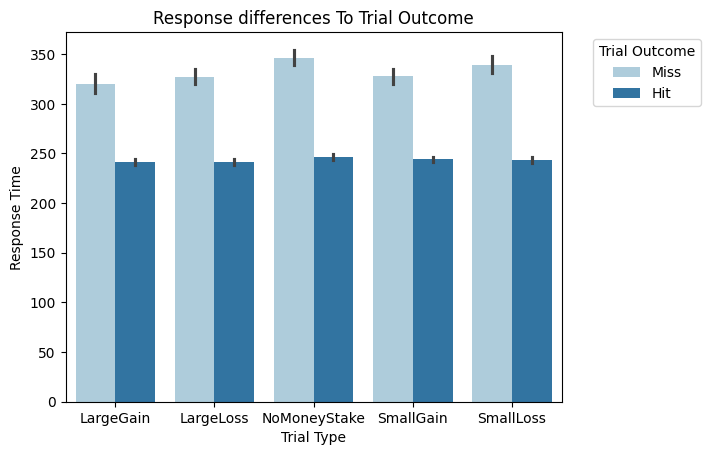

In [21]:
sns.barplot(
    x='TRIAL_TYPE',
    y='Response Time',
    hue='stimulus_outcome',
    data=concatenated_df_rts,
    palette='Paired',
)
plt.legend(title='Trial Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Response Time')
plt.xlabel('Trial Type')
plt.title('Response differences To Trial Outcome')
plt.show()

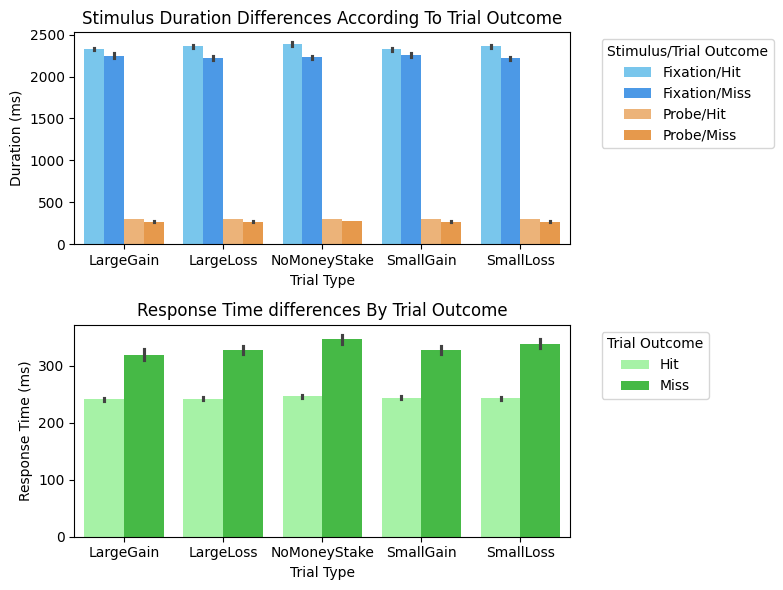

In [22]:
# Put the above two plots together
two_pairs = ['#66CCFF', '#3399FF', '#FFB366', '#FF9933']
one_pair = ['#99FF99', '#33CC33']


concatenated_df_duration_long_no_td1 = concatenated_df_duration_long.loc[
    concatenated_df_duration_long['Stimulus'] != 'TD1', :
].copy()
concatenated_df_duration_long_no_td1['duration_ms'] = (
    concatenated_df_duration_long_no_td1['DURATION'] * 1000
)

fig, axs = plt.subplots(2, 1, figsize=(8, 6))

sns.barplot(
    x='TRIAL_TYPE',
    y='duration_ms',
    hue='stimulus_outcome',
    data=concatenated_df_duration_long_no_td1,
    palette=two_pairs,
    hue_order=['Fixation/Hit', 'Fixation/Miss', 'Probe/Hit', 'Probe/Miss'],
    ax=axs[0],
)

axs[0].legend(
    title='Stimulus/Trial Outcome', bbox_to_anchor=(1.05, 1), loc='upper left'
)
axs[0].set_ylabel('Duration (ms)')
axs[0].set_xlabel('Trial Type')
axs[0].set_title('Stimulus Duration Differences According To Trial Outcome')

sns.barplot(
    x='TRIAL_TYPE',
    y='Response Time',
    hue='stimulus_outcome',
    data=concatenated_df_rts,
    palette=one_pair,
    ax=axs[1],
    hue_order=['Hit', 'Miss'],
)
axs[1].legend(title='Trial Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1].set_ylabel('Response Time (ms)')
axs[1].set_xlabel('Trial Type')
axs[1].set_title('Response Time differences By Trial Outcome')
plt.tight_layout()
plt.savefig(f'{figure_output_path}/durations_rts_by_hit_miss.pdf')

plt.show()

In [23]:
concatenated_df_duration_long_no_td1
concatenated_df_duration_long_no_td1[['Stimulus_new', 'Outcome']] = (
    concatenated_df_duration_long_no_td1['stimulus_outcome'].str.split('/', expand=True)
)
concatenated_df_duration_long_no_td1

duration_data_fixation = concatenated_df_duration_long_no_td1[
    concatenated_df_duration_long_no_td1['Stimulus_new'] == 'Fixation'
]
duration_data_miss = duration_data_fixation[duration_data_fixation['Outcome'] == 'Miss']


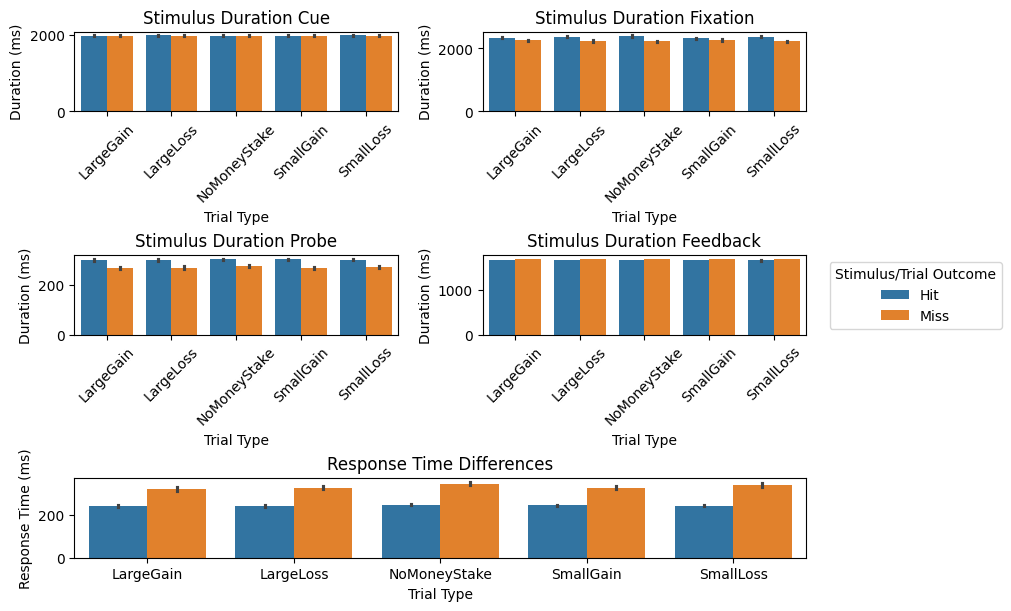

In [24]:
two_pairs = ['#66CCFF', '#3399FF', '#FFB366', '#FF9933']
one_pair = ['#99FF99', '#33CC33']
axs_label_fontsize = 10

concatenated_df_duration_long_no_td1 = concatenated_df_duration_long[
    concatenated_df_duration_long['Stimulus'] != 'TD1'
].copy()
concatenated_df_duration_long_no_td1['duration_ms'] = (
    concatenated_df_duration_long_no_td1['DURATION'] * 1000
)
concatenated_df_duration_long_no_td1[['Stimulus_new', 'Outcome']] = (
    concatenated_df_duration_long_no_td1['stimulus_outcome'].str.split('/', expand=True)
)

duration_data_cue = concatenated_df_duration_long_no_td1[
    concatenated_df_duration_long_no_td1['Stimulus_new'] == 'Cue'
]

duration_data_fixation = concatenated_df_duration_long_no_td1[
    concatenated_df_duration_long_no_td1['Stimulus_new'] == 'Fixation'
]
duration_data_probe = concatenated_df_duration_long_no_td1[
    concatenated_df_duration_long_no_td1['Stimulus_new'] == 'Probe'
]

duration_data_feedback = concatenated_df_duration_long_no_td1[
    concatenated_df_duration_long_no_td1['Stimulus_new'] == 'Feedback'
]

# fig, axs = plt.subplots(2, 1, figsize=(8,6))
fig = plt.figure(constrained_layout=True, figsize=(10, 6))
gs = GridSpec(3, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, :])

sns.barplot(
    x='TRIAL_TYPE',
    y='duration_ms',
    hue='Outcome',
    data=duration_data_cue,
    hue_order=['Hit', 'Miss'],
    ax=ax1,
    legend=False,
)
ax1.set_ylabel('Duration (ms)', fontsize=axs_label_fontsize)
ax1.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax1.set_title('Stimulus Duration Cue')
ax1.tick_params(axis='x', labelsize=10, rotation=45)

sns.barplot(
    x='TRIAL_TYPE',
    y='duration_ms',
    hue='Outcome',
    data=duration_data_fixation,
    hue_order=['Hit', 'Miss'],
    ax=ax2,
    legend=False,
)
ax2.set_ylabel('Duration (ms)', fontsize=axs_label_fontsize)
ax2.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax2.set_title('Stimulus Duration Fixation')
ax2.tick_params(axis='x', labelsize=10, rotation=45)

sns.barplot(
    x='TRIAL_TYPE',
    y='duration_ms',
    hue='Outcome',
    data=duration_data_probe,
    hue_order=['Hit', 'Miss'],
    ax=ax3,
    legend=False,
)
ax3.set_ylabel('Duration (ms)', fontsize=axs_label_fontsize)
ax3.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax3.set_title('Stimulus Duration Probe')
ax3.tick_params(axis='x', labelsize=10, rotation=45)
# ax3.legend(title='Stimulus/Trial Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')

sns.barplot(
    x='TRIAL_TYPE',
    y='duration_ms',
    hue='Outcome',
    data=duration_data_feedback,
    hue_order=['Hit', 'Miss'],
    ax=ax4,
    legend=True,
)
ax4.set_ylabel('Duration (ms)', fontsize=axs_label_fontsize)
ax4.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax4.set_title('Stimulus Duration Feedback')
ax4.tick_params(axis='x', labelsize=10, rotation=45)
ax4.legend(title='Stimulus/Trial Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')


sns.barplot(
    x='TRIAL_TYPE',
    y='Response Time',
    hue='stimulus_outcome',
    data=concatenated_df_rts,
    ax=ax5,
    hue_order=['Hit', 'Miss'],
    legend=False,
)
ax5.set_ylabel('Response Time (ms)', fontsize=axs_label_fontsize)
ax5.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax5.set_title('Response Time Differences')
plt.savefig(f'{figure_output_path}/durations_rts_by_hit_miss_3panel_bar.pdf')

plt.show()

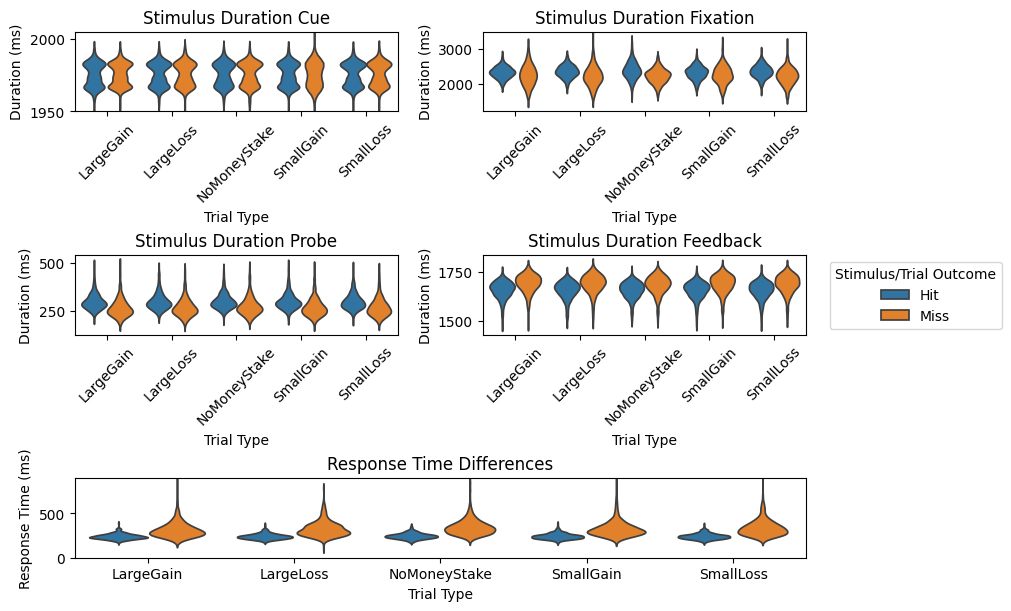

In [25]:
# Try using different plotting styles


# fig, axs = plt.subplots(2, 1, figsize=(8,6))
fig = plt.figure(constrained_layout=True, figsize=(10, 6))
gs = GridSpec(3, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, :])

sns.violinplot(
    x='TRIAL_TYPE',
    y='duration_ms',
    hue='Outcome',
    data=duration_data_cue,
    hue_order=['Hit', 'Miss'],
    ax=ax1,
    legend=False,
    inner=None,
)
ax1.set_ylim(1950, 2005)
ax1.set_ylabel('Duration (ms)', fontsize=axs_label_fontsize)
ax1.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax1.set_title('Stimulus Duration Cue')
ax1.tick_params(axis='x', labelsize=10, rotation=45)

sns.violinplot(
    x='TRIAL_TYPE',
    y='duration_ms',
    hue='Outcome',
    data=duration_data_fixation,
    hue_order=['Hit', 'Miss'],
    ax=ax2,
    legend=False,
    inner=None,
)
ax2.set_ylim(1200, 3500)
ax2.set_ylabel('Duration (ms)', fontsize=axs_label_fontsize)
ax2.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax2.set_title('Stimulus Duration Fixation')
ax2.tick_params(axis='x', labelsize=10, rotation=45)

sns.violinplot(
    x='TRIAL_TYPE',
    y='duration_ms',
    hue='Outcome',
    data=duration_data_probe,
    hue_order=['Hit', 'Miss'],
    ax=ax3,
    legend=False,
    inner=None,
)
ax3.set_ylabel('Duration (ms)', fontsize=axs_label_fontsize)
ax3.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax3.set_title('Stimulus Duration Probe')
ax3.tick_params(axis='x', labelsize=10, rotation=45)
# ax3.legend(title='Stimulus/Trial Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')

sns.violinplot(
    x='TRIAL_TYPE',
    y='duration_ms',
    hue='Outcome',
    data=duration_data_feedback,
    hue_order=['Hit', 'Miss'],
    ax=ax4,
    legend=True,
    inner=None,
)
ax4.set_ylabel('Duration (ms)', fontsize=axs_label_fontsize)
ax4.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax4.set_title('Stimulus Duration Feedback')
ax4.tick_params(axis='x', labelsize=10, rotation=45)
ax4.legend(title='Stimulus/Trial Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')


sns.violinplot(
    x='TRIAL_TYPE',
    y='Response Time',
    hue='stimulus_outcome',
    data=concatenated_df_rts,
    ax=ax5,
    hue_order=['Hit', 'Miss'],
    legend=False,
    inner=None,
)
ax5.set_ylim(0, 900)
ax5.set_ylabel('Response Time (ms)', fontsize=axs_label_fontsize)
ax5.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax5.set_title('Response Time Differences')
plt.savefig(f'{figure_output_path}/durations_rts_by_hit_miss_3panel_violin.pdf')

plt.show()

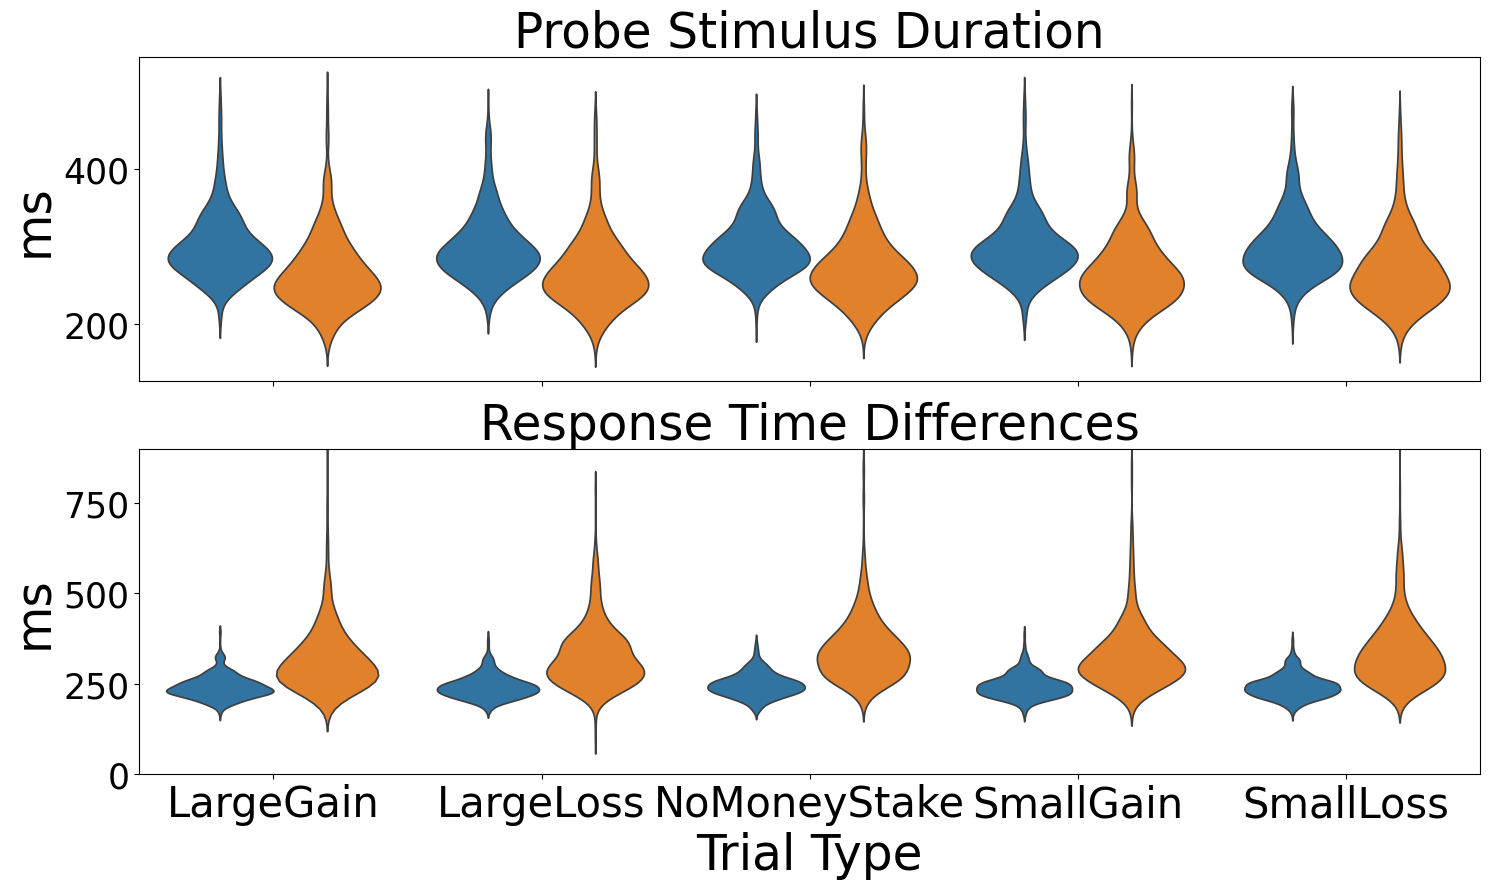

In [26]:
# For Michael slides

fig, axs = plt.subplots(2, 1, figsize=(15, 9), sharex=True)
# fig = plt.figure(constrained_layout=True, figsize=(10, 6))
# gs = GridSpec(1, 2, figure=fig)
# ax1 = fig.add_subplot(gs[0, :])
# ax2 = fig.add_subplot(gs[1, :])


sns.violinplot(
    x='TRIAL_TYPE',
    y='duration_ms',
    hue='Outcome',
    data=duration_data_probe,
    hue_order=['Hit', 'Miss'],
    ax=axs[0],
    legend=False,
    inner=None,
)
axs[0].set_ylabel('ms', fontsize=35)
axs[0].set_xlabel('')
axs[0].set_title('Probe Stimulus Duration', fontsize=35)
axs[0].tick_params(axis='x', labelsize=25)
axs[0].tick_params(axis='y', labelsize=25)

# ax3.legend(title='Stimulus/Trial Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')

sns.violinplot(
    x='TRIAL_TYPE',
    y='Response Time',
    hue='stimulus_outcome',
    data=concatenated_df_rts,
    ax=axs[1],
    hue_order=['Hit', 'Miss'],
    legend=False,
    inner=None,
)
axs[1].set_ylim(0, 900)
axs[1].set_ylabel('ms', fontsize=35)
axs[1].set_xlabel('Trial Type', fontsize=35)
axs[1].tick_params(axis='x', labelsize=30)
axs[1].set_title('Response Time Differences', fontsize=35)
axs[1].tick_params(axis='y', labelsize=25)
plt.tight_layout()
plt.savefig(f'{figure_output_path}/probe_durations_rts_by_hit_miss_michael.pdf')

plt.show()

In [27]:
duration_data_cue.groupby(['TRIAL_TYPE', 'Outcome'])['duration_ms'].mean()

TRIAL_TYPE    Outcome
LargeGain     Hit        1975.122356
              Miss       1975.381972
LargeLoss     Hit        1975.523650
              Miss       1975.334656
NoMoneyStake  Hit        1975.315683
              Miss       1975.389691
SmallGain     Hit        1975.247098
              Miss       1974.820085
SmallLoss     Hit        1975.539007
              Miss       1975.414108
Name: duration_ms, dtype: float64

In [28]:
fb_avgs = duration_data_feedback.groupby(['TRIAL_TYPE', 'Outcome'])[
    'duration_ms'
].mean()
print(fb_avgs)
print(fb_avgs.mean())

TRIAL_TYPE    Outcome
LargeGain     Hit        1656.022526
              Miss       1689.160060
LargeLoss     Hit        1656.398891
              Miss       1687.424922
NoMoneyStake  Hit        1655.085811
              Miss       1681.072169
SmallGain     Hit        1654.900088
              Miss       1686.652978
SmallLoss     Hit        1654.953932
              Miss       1685.935664
Name: duration_ms, dtype: float64
1670.7607041531344


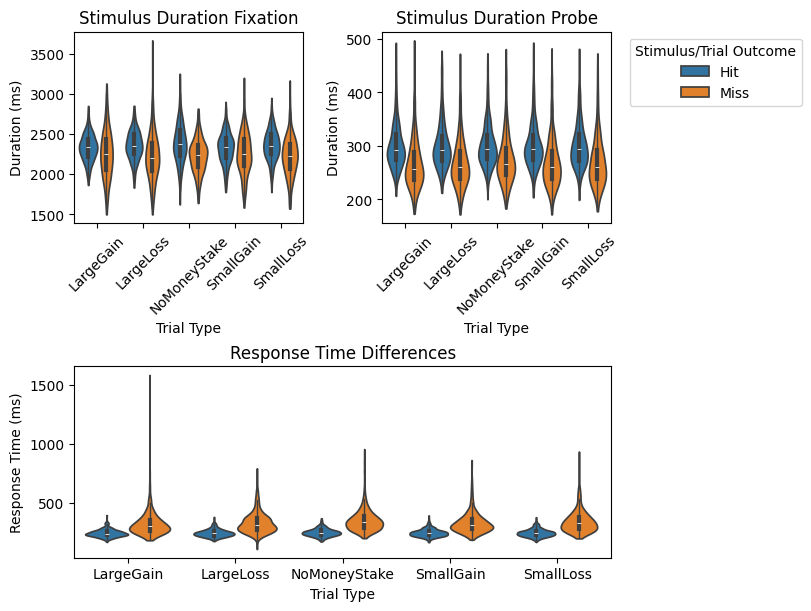

In [29]:
two_pairs = ['#66CCFF', '#3399FF', '#FFB366', '#FF9933']
one_pair = ['#99FF99', '#33CC33']
axs_label_fontsize = 10

concatenated_df_duration_long_no_td1 = concatenated_df_duration_long[
    concatenated_df_duration_long['Stimulus'] != 'TD1'
].copy()
concatenated_df_duration_long_no_td1['duration_ms'] = (
    concatenated_df_duration_long_no_td1['DURATION'] * 1000
)
concatenated_df_duration_long_no_td1[['Stimulus_new', 'Outcome']] = (
    concatenated_df_duration_long_no_td1['stimulus_outcome'].str.split('/', expand=True)
)

duration_data_fixation = concatenated_df_duration_long_no_td1[
    concatenated_df_duration_long_no_td1['Stimulus_new'] == 'Fixation'
]
duration_data_probe = concatenated_df_duration_long_no_td1[
    concatenated_df_duration_long_no_td1['Stimulus_new'] == 'Probe'
]

fig = plt.figure(constrained_layout=True, figsize=(8, 6))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

sns.violinplot(
    x='TRIAL_TYPE',
    y='duration_ms',
    hue='Outcome',
    data=duration_data_fixation,
    hue_order=['Hit', 'Miss'],
    cut=0,
    inner_kws=dict(box_width=3),
    ax=ax1,
    legend=False,
)
ax1.set_ylabel('Duration (ms)', fontsize=axs_label_fontsize)
ax1.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax1.set_title('Stimulus Duration Fixation')
ax1.tick_params(axis='x', labelsize=10, rotation=45)

sns.violinplot(
    x='TRIAL_TYPE',
    y='duration_ms',
    hue='Outcome',
    data=duration_data_probe,
    hue_order=['Hit', 'Miss'],
    cut=0,
    inner_kws=dict(box_width=3),
    ax=ax2,
    legend=True,
)

ax2.set_ylabel('Duration (ms)', fontsize=axs_label_fontsize)
ax2.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax2.set_title('Stimulus Duration Probe')
ax2.tick_params(axis='x', labelsize=10, rotation=45)
ax2.legend(title='Stimulus/Trial Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.violinplot(
    x='TRIAL_TYPE',
    y='Response Time',
    hue='stimulus_outcome',
    data=concatenated_df_rts,
    ax=ax3,
    hue_order=['Hit', 'Miss'],
    cut=0,
    inner_kws=dict(box_width=3),
    legend=False,
)

ax3.set_ylabel('Response Time (ms)', fontsize=axs_label_fontsize)
ax3.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax3.set_title('Response Time Differences')
plt.savefig(f'{figure_output_path}/durations_rts_by_hit_miss_violin.pdf')

plt.show()

# Look at stimulus durations and RTs by Correct/Too Slow/Too Soon

In [30]:
def get_response_proportions(sub):
    events = get_events_df_for_subject(sub, dataset='ABCD')
    response_counts = events['Response'].value_counts(normalize=True) * 100
    response_counts = response_counts.reset_index()
    response_dict = {
        row['Response']: [row['proportion']] for _, row in response_counts.iterrows()
    }
    return response_dict

In [31]:
for sub in range(1, 501):
    response_dict = get_response_proportions(sub)
    if sub == 1:
        all_sub_response_proportions = response_dict
    else:
        for key in response_dict:
            all_sub_response_proportions[key].extend(response_dict[key])


In [32]:
for key, val in all_sub_response_proportions.items():
    print(key)
    mean_val = np.mean(np.array(val))
    print(f'# of subjects = {len(val)}')
    print(f'Averaged proportion = {mean_val}\n')


Correct Response!
# of subjects = 500
Averaged proportion = 56.786

You pressed too slow!
# of subjects = 500
Averaged proportion = 36.236

You pressed too soon!
# of subjects = 495
Averaged proportion = 7.048484848484849



In [33]:
def get_all_durations_response_type(sub):
    events = get_events_df_for_subject(sub, dataset='ABCD')
    events['TD1_ONSET'] = events['PROBE_ONSET'] + events['PROBE_DURATION']
    events['TD1_DURATION'] = events['FEEDBACK_ONSET'] - events['TD1_ONSET']
    events = events.rename(
        columns={
            'FIXATION_DURATION': 'Fixation_DURATION',
            'PROBE_DURATION': 'Probe_DURATION',
        }
    )
    average_dur = events.groupby(['TRIAL_TYPE', 'Response'])[
        ['Fixation_DURATION', 'Probe_DURATION', 'TD1_DURATION']
    ].mean()
    average_dur = average_dur.reset_index()
    return average_dur


all_dfs_duration_response_type = []
for sub in range(1, 501):
    df = get_all_durations_response_type(sub)
    all_dfs_duration_response_type.append(df)
concatenated_df_duration_response_type = pd.concat(
    all_dfs_duration_response_type, ignore_index=True
)

In [34]:
concatenated_df_duration_response_type_long = pd.melt(
    concatenated_df_duration_response_type,
    id_vars=['TRIAL_TYPE', 'Response'],
    value_vars=[
        col
        for col in concatenated_df_duration_response_type.columns
        if 'DURATION' in col
    ],
    var_name='Stimulus',
    value_name='DURATION',
)
concatenated_df_duration_response_type_long['Stimulus'] = (
    concatenated_df_duration_response_type_long['Stimulus'].str.replace('_DURATION', '')
)
concatenated_df_duration_response_type_long['stimulus_outcome'] = (
    concatenated_df_duration_response_type_long.apply(
        lambda row: f"{row['Stimulus']}/{row['Response']}", axis=1
    )
)


In [35]:
def get_all_rts_response_type(sub):
    events = get_events_df_for_subject(sub, dataset='ABCD')
    events = events.rename(columns={'RT_corrected': 'Response Time'})
    average_rt = events.groupby(['TRIAL_TYPE', 'Response'])[['Response Time']].mean()
    average_rt = average_rt.reset_index()
    return average_rt


all_dfs_rts_response_type = []
for sub in range(1, 501):
    df = get_all_rts_response_type(sub)
    all_dfs_rts_response_type.append(df)
concatenated_df_rts_response_type = pd.concat(
    all_dfs_rts_response_type, ignore_index=True
)

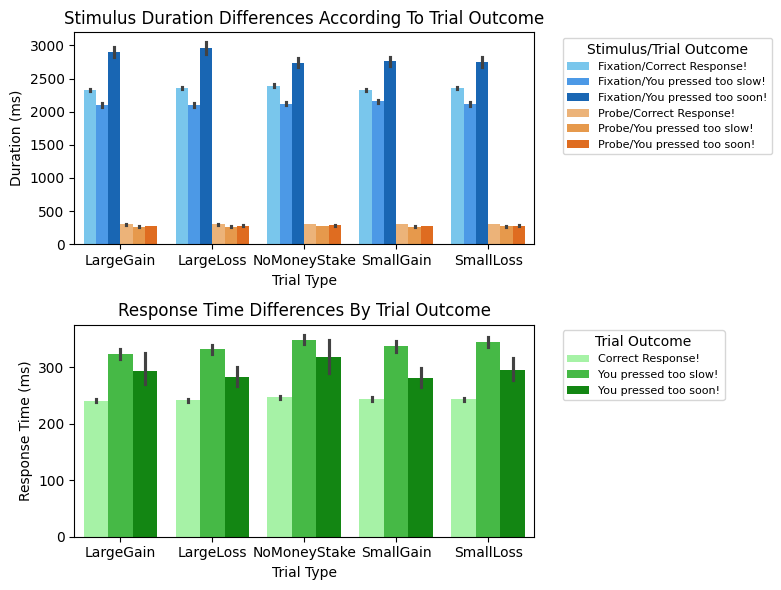

In [36]:
concatenated_df_duration_response_type_long_no_td1 = (
    concatenated_df_duration_response_type_long[
        concatenated_df_duration_response_type_long['Stimulus'] != 'TD1'
    ].copy()
)

concatenated_df_duration_response_type_long_no_td1['duration_ms'] = (
    concatenated_df_duration_response_type_long_no_td1['DURATION'].values * 1000
)


# colors
two_triples = ['#66CCFF', '#3399FF', '#0066CC', '#FFB366', '#FF9933', '#FF6600']
one_triple = ['#99FF99', '#33CC33', '#009900']


fig_path = f'{figure_output_path}/durations_rts_by_trial_type.pdf'
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

bar_palette = sns.color_palette('Paired')

sns.barplot(
    x='TRIAL_TYPE',
    y='duration_ms',
    hue='stimulus_outcome',
    data=concatenated_df_duration_response_type_long_no_td1,
    palette=two_triples,
    hue_order=[
        'Fixation/Correct Response!',
        'Fixation/You pressed too slow!',
        'Fixation/You pressed too soon!',
        'Probe/Correct Response!',
        'Probe/You pressed too slow!',
        'Probe/You pressed too soon!',
    ],
    ax=axs[0],
)

axs[0].legend(
    title='Stimulus/Trial Outcome',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=8,
)
axs[0].set_ylabel('Duration (ms)')
axs[0].set_xlabel('Trial Type')
axs[0].set_title('Stimulus Duration Differences According To Trial Outcome')

sns.barplot(
    x='TRIAL_TYPE',
    y='Response Time',
    hue='Response',
    data=concatenated_df_rts_response_type,
    palette=one_triple,
    ax=axs[1],
    hue_order=['Correct Response!', 'You pressed too slow!', 'You pressed too soon!'],
)
axs[1].legend(
    title='Trial Outcome', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8
)
axs[1].set_ylabel('Response Time (ms)')
axs[1].set_xlabel('Trial Type')
axs[1].set_title('Response Time Differences By Trial Outcome')

plt.tight_layout()
plt.savefig(fig_path, bbox_inches='tight')
plt.show()


/var/folders/y4/qn1yzt191kb4h4vwfbmgvt340000gn/T/ipykernel_30308/530350615.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


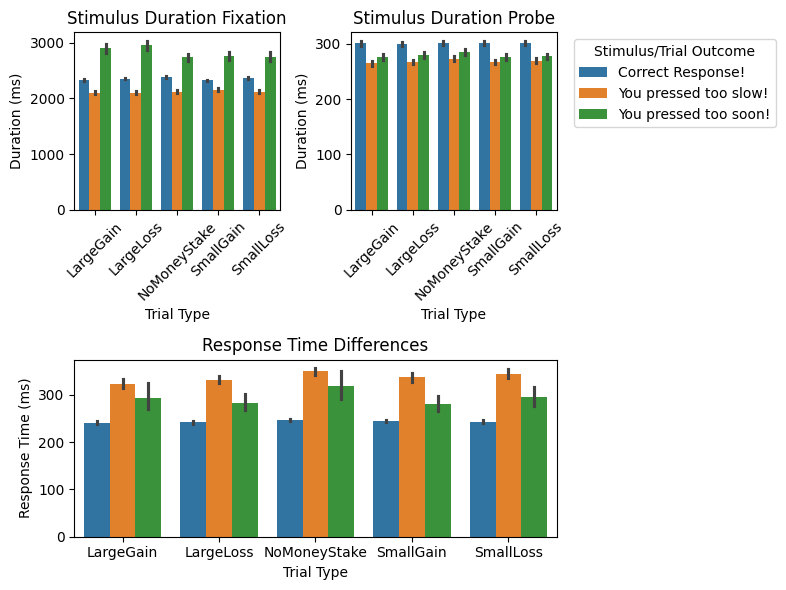

In [37]:
duration_data_fixation = concatenated_df_duration_response_type_long_no_td1[
    concatenated_df_duration_response_type_long_no_td1['Stimulus'] == 'Fixation'
]
duration_data_probe = concatenated_df_duration_response_type_long_no_td1[
    concatenated_df_duration_response_type_long_no_td1['Stimulus'] == 'Probe'
]

fig = plt.figure(constrained_layout=True, figsize=(8, 6))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

sns.barplot(
    x='TRIAL_TYPE',
    y='duration_ms',
    hue='Response',
    data=duration_data_fixation,
    hue_order=['Correct Response!', 'You pressed too slow!', 'You pressed too soon!'],
    ax=ax1,
    legend=False,
)
ax1.set_ylabel('Duration (ms)', fontsize=axs_label_fontsize)
ax1.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax1.set_title('Stimulus Duration Fixation')
ax1.tick_params(axis='x', labelsize=10, rotation=45)
# ax1.legend(
#     title='Stimulus/Trial Outcome',  loc='upper left'
# )
sns.barplot(
    x='TRIAL_TYPE',
    y='duration_ms',
    hue='Response',
    data=duration_data_probe,
    hue_order=['Correct Response!', 'You pressed too slow!', 'You pressed too soon!'],
    ax=ax2,
    legend=True,
)

ax2.set_ylabel('Duration (ms)', fontsize=axs_label_fontsize)
ax2.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax2.set_title('Stimulus Duration Probe')
ax2.tick_params(axis='x', labelsize=10, rotation=45)
ax2.legend(title='Stimulus/Trial Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.barplot(
    x='TRIAL_TYPE',
    y='Response Time',
    hue='Response',
    data=concatenated_df_rts_response_type,
    ax=ax3,
    hue_order=['Correct Response!', 'You pressed too slow!', 'You pressed too soon!'],
    legend=False,
)

ax3.set_ylabel('Response Time (ms)', fontsize=axs_label_fontsize)
ax3.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax3.set_title('Response Time Differences')
plt.tight_layout()
plt.savefig(f'{figure_output_path}/durations_rts_by_trial_outcome_3_panel_barplot.pdf')

plt.show()

/var/folders/y4/qn1yzt191kb4h4vwfbmgvt340000gn/T/ipykernel_30308/1565734530.py:62: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


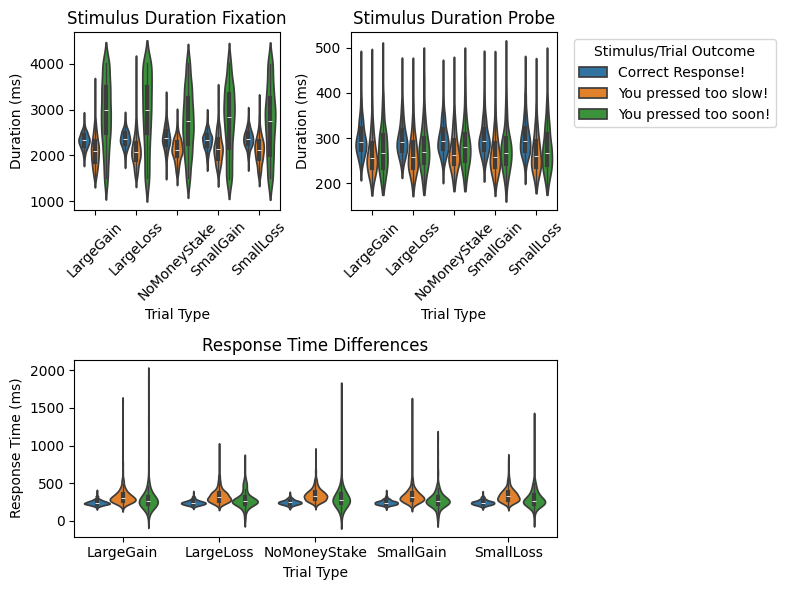

In [38]:
# violin plots

duration_data_fixation = concatenated_df_duration_response_type_long_no_td1[
    concatenated_df_duration_response_type_long_no_td1['Stimulus'] == 'Fixation'
]
duration_data_probe = concatenated_df_duration_response_type_long_no_td1[
    concatenated_df_duration_response_type_long_no_td1['Stimulus'] == 'Probe'
]

fig = plt.figure(constrained_layout=True, figsize=(8, 6))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

sns.violinplot(
    x='TRIAL_TYPE',
    y='duration_ms',
    hue='Response',
    data=duration_data_fixation,
    hue_order=['Correct Response!', 'You pressed too slow!', 'You pressed too soon!'],
    inner_kws=dict(box_width=3),
    ax=ax1,
    legend=False,
)
ax1.set_ylabel('Duration (ms)', fontsize=axs_label_fontsize)
ax1.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax1.set_title('Stimulus Duration Fixation')
ax1.tick_params(axis='x', labelsize=10, rotation=45)

sns.violinplot(
    x='TRIAL_TYPE',
    y='duration_ms',
    hue='Response',
    data=duration_data_probe,
    hue_order=['Correct Response!', 'You pressed too slow!', 'You pressed too soon!'],
    cut=0,
    inner_kws=dict(box_width=3),
    ax=ax2,
    legend=True,
)

ax2.set_ylabel('Duration (ms)', fontsize=axs_label_fontsize)
ax2.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax2.set_title('Stimulus Duration Probe')
ax2.tick_params(axis='x', labelsize=10, rotation=45)
ax2.legend(title='Stimulus/Trial Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.violinplot(
    x='TRIAL_TYPE',
    y='Response Time',
    hue='Response',
    data=concatenated_df_rts_response_type,
    ax=ax3,
    hue_order=['Correct Response!', 'You pressed too slow!', 'You pressed too soon!'],
    inner_kws=dict(box_width=3),
    legend=False,
)

ax3.set_ylabel('Response Time (ms)', fontsize=axs_label_fontsize)
ax3.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax3.set_title('Response Time Differences')
plt.tight_layout()
plt.savefig(f'{figure_output_path}/durations_rts_by_trial_outcome_violin.pdf')

plt.show()

In [39]:
average_duration_per_stimulus_outcome = (
    concatenated_df_duration_response_type_long_no_td1.groupby('stimulus_outcome')[
        'DURATION'
    ]
    .mean()
    .reset_index()
)
print(average_duration_per_stimulus_outcome)

                 stimulus_outcome  DURATION
0      Fixation/Correct Response!  2.352119
1  Fixation/You pressed too slow!  2.119275
2  Fixation/You pressed too soon!  2.816988
3         Probe/Correct Response!  0.301271
4     Probe/You pressed too slow!  0.268304
5     Probe/You pressed too soon!  0.278877


In [40]:
print('Fixation/You pressed too soon - Fixation/You pressed too slow')
print(
    average_duration_per_stimulus_outcome.loc[
        average_duration_per_stimulus_outcome['stimulus_outcome'].str.contains(
            'Fixation/You pressed too soon'
        ),
        'DURATION',
    ].values
    - average_duration_per_stimulus_outcome.loc[
        average_duration_per_stimulus_outcome['stimulus_outcome'].str.contains(
            'Fixation/You pressed too slow'
        ),
        'DURATION',
    ].values
)

print('Probe/You pressed too soon - Probe/You pressed too slow')
print(
    average_duration_per_stimulus_outcome.loc[
        average_duration_per_stimulus_outcome['stimulus_outcome'].str.contains(
            'Probe/You pressed too soon'
        ),
        'DURATION',
    ].values
    - average_duration_per_stimulus_outcome.loc[
        average_duration_per_stimulus_outcome['stimulus_outcome'].str.contains(
            'Probe/You pressed too slow'
        ),
        'DURATION',
    ].values
)

Fixation/You pressed too soon - Fixation/You pressed too slow
[0.69771288]
Probe/You pressed too soon - Probe/You pressed too slow
[0.01057288]


In [41]:
average_rt_per_stimulus_outcome = (
    concatenated_df_rts_response_type.groupby('Response')['Response Time']
    .mean()
    .reset_index()
)

print('Probe/You pressed too slow - Probe/You pressed too soon')
print(
    average_rt_per_stimulus_outcome.loc[
        average_rt_per_stimulus_outcome['Response'].str.contains(
            'You pressed too slow'
        ),
        'Response Time',
    ].values
    - average_rt_per_stimulus_outcome.loc[
        average_rt_per_stimulus_outcome['Response'].str.contains(
            'You pressed too soon'
        ),
        'Response Time',
    ].values
)

Probe/You pressed too slow - Probe/You pressed too soon
[42.81537482]
